# Integrative analysis of pathway deregulation in obesity
### Removing batch effects and merging datasets with SVD
This notebook shows, step-by-step, how to use Singular Value Decomposition to remove batch effects. We use a two-step filtering procedure as descrived in


F. Font-Clos, S. Zapperi, C.A.M. La Porta  
Integrative analysis of pathway deregulation in obesity  
*npj Systems Biology and Applications (accepted)*, 2017  
[insert link](link). 

**Note:** If you want to try it out with your own data, then check [SVDmerge](https://github.com/ComplexityBiosystems/SVDmerge): a plain python package [available here](https://github.com/ComplexityBiosystems/SVDmerge) that works natively with pandas DataFrames and turns batch-effects removal and data merging into a one-liner.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import ks_2samp

import copy

/Users/fran/miniconda2/envs/obesity-score/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Load the gene expression data
The raw gene-expression data is available at [GEO](http://www.ncbi.nlm.nih.gov/gds) under the following identifiers:
+ GSE2508
+ GSE26637
+ GSE27949
+ GSE48964

The pre-processed data in the form of pickled pandas dataframes can be found here: [data/gene_expression/](../data/gene_expression). For each batch there are two pickled pandas dataframes: `*_geno.p` contains the gene-expression matrix (samples in rows, genes in columns) and `*_pheno.p` contains the clinical data (samples in rows, features in columns).


Note that when loading the **geno** data, we perform a simple $\mathcal{L}_1$ normalization (features sum to 1 in linear space, for all samples). We also add a ``batch'' column to the **pheno** dataframe

In [2]:
def normalize_df(df):
    """
    input: pandas dataframe, values are log2 gene expression, genes in columns, samples in rows.
    output: same, with sum of genes equal 1 for all samples (in linear space).
    """
    
    # exponentiate
    x = pow(2.,df)
    
    # rows sum to 1
    x = x.div(x.sum(axis=1), axis=0)
    
    return np.log2(x)

In [3]:
gselist = ["GSE2508","GSE26637","GSE27949","GSE48964"]
dfs = {}
for gse in gselist:
    dfs[gse]=(normalize_df(pd.read_pickle("../data/gene_expression/"+gse+"_geno.p")))
geno = pd.concat(dfs)
geno.index = geno.index.droplevel(0)

In [4]:
dfs = {}
for gse in gselist:
    tmp = pd.read_pickle("../data/gene_expression/"+gse+"_pheno.p")
    tmp["batch"] = gse
    dfs[gse]=(tmp)
pheno = pd.concat(dfs)
pheno.index = pheno.index.droplevel(0)

We drop all genes for which there is **missing data**

In [5]:
geno.drop(geno.columns[geno.isnull().sum()!=0],axis=1,inplace=True)

And print a summary of what we have so far:

In [6]:
print "batch \t\t lean \t overw \t obese \t total"
print "---"
for gse in gselist:
    l = ((pheno["batch"]==gse) & (pheno["cbmi"]=="lean")).sum()
    over = ((pheno["batch"]==gse) & (pheno["cbmi"]=="overweight")).sum()
    o = ((pheno["batch"]==gse) & (pheno["cbmi"]=="obese")).sum()
    print "%s \t %d \t %d \t %d \t %d" % (gse,l,over,o,l+over+o)
l =  (pheno["cbmi"]=="lean").sum()
over = ((pheno["cbmi"]=="overweight")).sum()
o = ((pheno["cbmi"]=="obese")).sum()
print "---"
print "%s \t %d \t %d \t %d \t %d" % ("ALL\t",l,over,o,l+over+o)

batch 		 lean 	 overw 	 obese 	 total
---
GSE2508 	 20 	 0 	 19 	 39
GSE26637 	 10 	 0 	 10 	 20
GSE27949 	 6 	 10 	 17 	 33
GSE48964 	 3 	 0 	 3 	 6
---
ALL	 	 39 	 10 	 49 	 98


It turns out that only batch 3 (GSE27949) has an intermediate **overweight** class. We discard those 10 patients

In [7]:
idx = pheno[(pheno["cbmi"]=="overweight")].index

geno.drop(idx,axis=0,inplace=True)
pheno.drop(idx,axis=0,inplace=True)

In the end, the final **number of genes and samples** is:

In [8]:
print "genes:",geno.shape[1]
print "samples (lean):",geno.loc[pheno.cbmi=="lean"].shape[0]
print "samples (obese):",geno.loc[pheno.cbmi=="obese"].shape[0]

genes: 13684
samples (lean): 39
samples (obese): 49


We keep a clean copy of the genotype dataframe, to be used later on.

In [9]:
ogeno = copy.deepcopy(geno)

### First SVD filtering
The function below does the following:
1. PCA to get eigengenes
2. Project the data onto each of the first $n$ eigengenes $v_i$, to get a unic scalar per patient, $\phi_i$
3. Do a **Kolmogorov-Smirnov 2 sample test** where the null hypothesis is that the distribution of $\phi_i$ for lean and obese is the same. This gives a $p-$ value $p_i$
4. return the array $P=(p_0,p_1, \dots, p_n)$

This way, plotting $-\ln(p_i)$ versus $i$ shows which eigengenes can differentiate between lean and obese. (See plots below)

In [10]:
def find_level(df,pheno,n=10):
    """
    returns 1./pvalue of distro of n first components being from different distros when split by cbmi
    args:
    df = dataframe with expression values
    pheno = dataframe with labels and metadata
    n = max numb of components
    """
    # make sure we have enough dimensions
    n=min(n,df.shape[0])
    
    res = []
    pca = PCA()
    trans = pca.fit_transform(df)
    df_trans = pd.DataFrame(data = trans[:,:n],index = df.index)
        
    for i in range(n):
        res.append([i,1/ks_2samp(
            df_trans.loc[(pheno.cbmi=="lean") | (pheno.cbmi=="overweight")].iloc[:,i],
            df_trans.loc[pheno.cbmi=="obese"].iloc[:,i]
        ).pvalue])
    return np.array(res).T

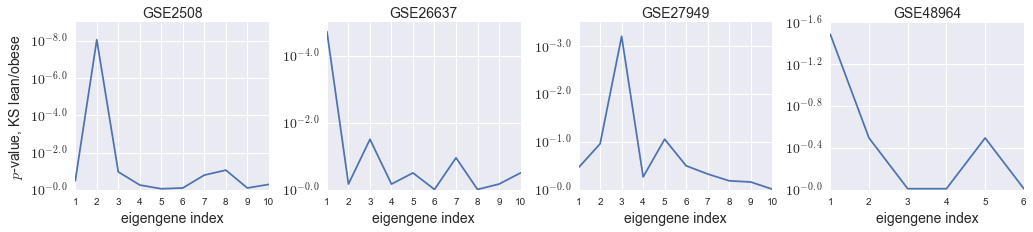

In [11]:
plt.figure(figsize=(17,3))
for i,batch in enumerate(gselist):
    plt.subplot(1,4,i+1)
    plt.title(batch,size=14)
    plt.xlabel("eigengene index",size=14)
    if i==0: plt.ylabel("$p$-value, KS lean/obese",size=14)
    y = np.log10(find_level(geno.loc[pheno.batch==batch],pheno)[1])
    plt.plot(range(1,y.shape[0]+1),y)
    yticks = plt.yticks()[0][::2]
    plt.yticks(yticks,["$10^{-%1.1f}$"%i for i in yticks],fontsize=14)
    plt.subplots_adjust(wspace=0.3)

Thus we see that lean/obese is not the main effect on all batches. The **first SVD filter** consists in filtering out those eigengenes ranked higher than the best lean/obese eigengene:

In [12]:
pca = PCA()

for batch in gselist:
    effect_strength = find_level(geno.loc[pheno.batch==batch],pheno)[1]
    while np.argmax(effect_strength)!=0:
        tmp = pca.fit_transform(geno.loc[pheno.batch==batch])
        tmp[:,0]=0
        print "One principal component was set to zero on batch",batch
        geno.loc[pheno.batch==batch] = pca.inverse_transform(tmp)
        effect_strength = find_level(geno.loc[pheno.batch==batch],pheno,n=min(10,geno.loc[pheno.batch==batch].shape[0]))[1]



One principal component was set to zero on batch GSE2508
One principal component was set to zero on batch GSE27949
One principal component was set to zero on batch GSE27949


After this step, all batches have the lean-obese effect localized in the first eigengene:

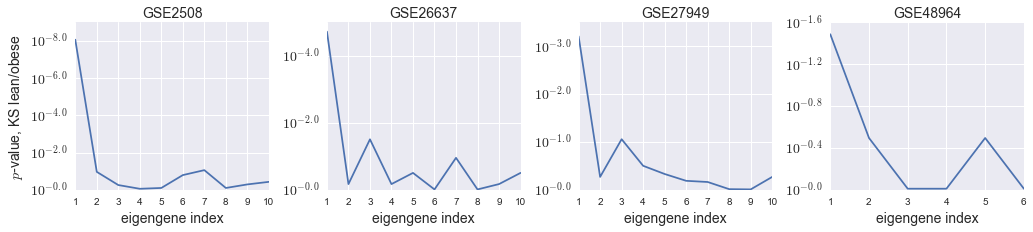

In [13]:
plt.figure(figsize=(17,3))
for i,batch in enumerate(gselist):
    plt.subplot(1,4,i+1)
    plt.title(batch,size=14)
    plt.xlabel("eigengene index",size=14)
    if i==0: plt.ylabel("$p$-value, KS lean/obese",size=14)
    y = np.log10(find_level(geno.loc[pheno.batch==batch],pheno)[1])
    plt.plot(range(1,y.shape[0]+1),y)
    yticks = plt.yticks()[0][::2]
    plt.yticks(yticks,["$10^{-%1.1f}$"%i for i in yticks],fontsize=14)
    plt.subplots_adjust(wspace=0.3)

### Second SVD filtering
Now we put all batches together and examine the eigengenes again: batch effects appear and the best lean/obese eigengene is in position 4:

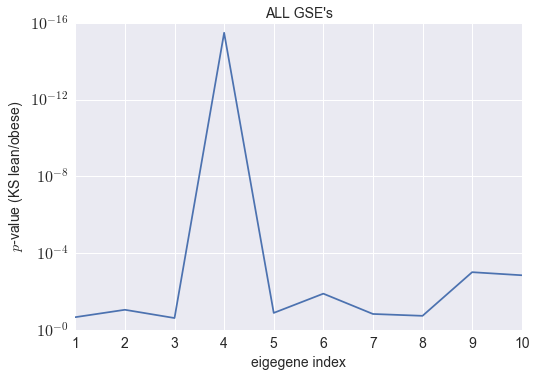

Picking eigengene number 4


In [14]:
plt.title("ALL GSE's",size=14)
plt.plot(range(1,11),np.log10(find_level(geno,pheno)[1]))
plt.xlabel("eigegene index",size=14)
plt.ylabel("$p$-value (KS lean/obese)",size=14)
plt.xticks(fontsize=14)
yticks = plt.yticks()[0][::2]
plt.yticks(yticks,["$10^{-%d}$"%i for i in yticks],fontsize=16)
plt.show()
eigvect_k = np.argmax(find_level(geno,pheno)[1])
print "Picking eigengene number",eigvect_k+1

The plot above shows $p$-value on a KS test between lean and obese, for each eigenvector $1,\dots,10$. It is clear that all the lean/obese effect is concentrated on the 4th eigenvector, so we kill the first 3 and save the transformed data in a new dataframe:

In [15]:
pca = PCA()
trans = pca.fit_transform(geno)
trans[:,:eigvect_k]=0
n_geno = pd.DataFrame(index = geno.index,columns=geno.columns,data=pca.inverse_transform(trans))

### Correlation Heatmaps before and after SVD-filtering
We plot correlations between samples in PCA spaces before and after the batch-effects removing process. This section reproduces Figure 1 (a,b,c) in the paper.

In [16]:
K=7

pca_geno = pd.DataFrame(
    data = PCA(n_components=K,whiten=True).fit_transform(geno),
    index = geno.index).T.corr()

pca_ogeno = pd.DataFrame(
    data = PCA(n_components=K,whiten=True).fit_transform(ogeno),
    index = ogeno.index).T.corr()

pca_ngeno = pd.DataFrame(
    data = PCA(n_components=K,whiten=True).fit_transform(n_geno),
    index = ogeno.index).T.corr()

In [17]:
matrix_colors_dict = dict(zip(np.unique(pheno.batch),
                              np.array([sns.palettes.light_palette(x)[2] for x in sns.color_palette(n_colors=7)])[[3,4,5,6]]
                             ))
matrix_colors_dict["lean"] = sns.palettes.light_palette("green")[1]
matrix_colors_dict["obese"] = sns.palettes.light_palette("red")[1]

In [18]:
# sort by batch
order = pheno.sort_values(by=["batch","cbmi"][::1]).index
batchcolors_bybatch = [matrix_colors_dict[pheno.loc[x,"batch"]] for x in order]
cbmicolors_bybatch = [matrix_colors_dict[pheno.loc[x,"cbmi"]] for x in order]

# sort by cbmi
order = pheno.sort_values(by=["batch","cbmi"][::-1]).index
batchcolors_bycbmi = [matrix_colors_dict[pheno.loc[x,"batch"]] for x in order]
cbmicolors_bycbmi = [matrix_colors_dict[pheno.loc[x,"cbmi"]] for x in order]

In [19]:
batch_sizes = np.array([39,20,23,6])
cbmi_size = np.array([39,49])

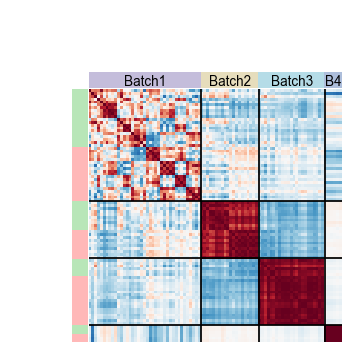

In [20]:
order = pheno.sort_values(by=["batch","cbmi"][::1]).index
big_ax = sns.clustermap(pca_geno.loc[order,order],
               row_cluster=False,col_cluster=False,
               row_colors=cbmicolors_bybatch,
               col_colors=batchcolors_bybatch,
               xticklabels=False,
               yticklabels=False,
               figsize=(6,6)
           )
ax = big_ax.ax_heatmap
big_ax.cax.set_visible(False)
N = n_geno.shape[(0)]
nn=0
for b,n in enumerate(batch_sizes[:-1]):
    nn=nn+n
    ax.axhline(N-nn,color="black")
    ax.axvline(nn,color="black")
    ax.text(nn-n/2,N+1,"Batch"+str(b+1),rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
ax.text(N-3,N+1,"B4",rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
plt.savefig("../output/figures/Figure1a.pdf")
plt.show()

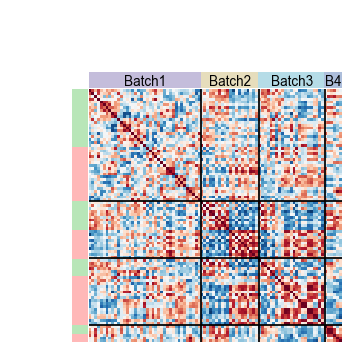

In [21]:
order = pheno.sort_values(by=["batch","cbmi"][::1]).index
big_ax = sns.clustermap(pca_ngeno.loc[order,order],
               row_cluster=False,col_cluster=False,
               row_colors=cbmicolors_bybatch,
               col_colors=batchcolors_bybatch,
               xticklabels=False,
               yticklabels=False,
               figsize=(6,6)
           )
ax = big_ax.ax_heatmap
big_ax.cax.set_visible(False)
N = n_geno.shape[(0)]
nn=0
for b,n in enumerate(batch_sizes[:-1]):
    nn=nn+n
    ax.axhline(N-nn,color="black")
    ax.axvline(nn,color="black")
    ax.text(nn-n/2,N+1,"Batch"+str(b+1),rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
ax.text(N-3,N+1,"B4",rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
plt.savefig("../output/figures/Figure1b.pdf")
plt.show()


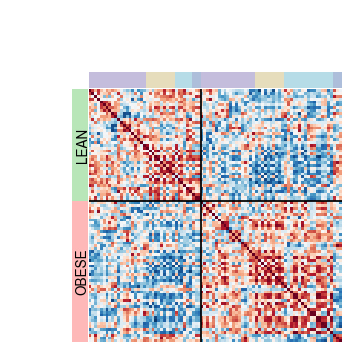

In [22]:
order = pheno.sort_values(by=["batch","cbmi"][::-1]).index
big_ax = sns.clustermap(pca_ngeno.loc[order,order],
               row_cluster=False,col_cluster=False,
               row_colors=cbmicolors_bycbmi,
               col_colors=batchcolors_bycbmi,
               xticklabels=False,
               yticklabels=False,
               figsize=(6,6)
           )
ax = big_ax.ax_heatmap
big_ax.cax.set_visible(False)
N = n_geno.shape[(0)]

ax.axhline(N-39,color="black")
ax.axvline(39,color="black")
ax.text(-4.5,49/2,"OBESE",rotation=90,fontsize=13.5,color="black",verticalalignment="center")
ax.text(-4.5,N-39/2,"LEAN",rotation=90,fontsize=13.5,color="black",verticalalignment="center")
plt.savefig("../output/figures/Figure1c.pdf")
plt.show()

### Save batches 1-4 merged
Finally, we save the merged batches:

In [31]:
n_geno.to_pickle("../output/batches1-4_merged/batch1234_geno.p")
pheno.to_pickle("../output/batches1-4_merged/batch1234_pheno.p")

We have thus removed most of the batch effects, and so batches 1 to 4 have been properly merged.

We can now proceed to identify the relevant genes in [this second notebook](2. Extracting the Obesity Signature.ipynb)